In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from collections import defaultdict
import numpy as np
import random
import torch

def enforce_reproducibility(seed=42):
  # Sets seed manually for both CPU and CUDA
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)

  # For atomic operations there is currently no simple way to enforce 
  # determinism, as the order of parallel operations is not known.
  # CUDNN
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  
  # System based
  random.seed(seed)
  np.random.seed(seed)

enforce_reproducibility()

In [3]:
# read_data.py

from html.parser import HTMLParser

class TxtEntryReader(HTMLParser):
    # this class reads tags in txt files
    # formatted as in trans_data.py
    entries = []
    entry = {}
    curr_tag = ""

    def handle_starttag(self,tag,attrs):
        self.curr_tag = tag

    def handle_endtag(self,tag):
        self.curr_tag = ""
        if tag == "entry":
            self.entries.append(self.entry)
            self.entry = {}

    def handle_data(self,data):
        if self.curr_tag != "" and self.curr_tag != "entry":
            self.entry[self.curr_tag] = data.strip()


def get_data_2(fname):
    # returns a list of entry-records
    parser = TxtEntryReader()
    with open("/content/drive/My Drive/NLP 2020W/data-txt/" + fname,"r") as f:
        d0 = f.read()
        parser.feed(d0)
    return parser.entries

def get_size(fname):
    return len(get_data_2(fname))

# we are interested in the fields
#d0 = get_data("train-eng.txt")
#print(d0[0]["question_txt"])
#print(d0[0]["doc_txt"])


In [4]:
!pip install langdetect

     |████████████████████████████████| 983kB 9.8MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp36-none-any.whl size=993195 sha256=c0068fe99dc30c7d6986a02636513368da77d20652c792cbb351004705a612ac
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect


In [5]:
# trans_data.py

import json
from langdetect import detect
from nltk.tokenize import word_tokenize
from nltk.tokenize import TreebankWordTokenizer as twt



def get_data_lines(s):
    retval = []
    with open("/content/drive/My Drive/NLP 2020W/tydiqa-v1.0-"+s+".jsonl","r") as f:
        retval = f.readlines()
    return retval

def save_txt(fname,txt):
    with open("/content/drive/My Drive/NLP 2020W/data-txt/" + fname,"w") as f:
        f.write(txt)

def create_tag(tag_name,tag_txt):
    retval  = "<" + tag_name + ">\n"
    retval += tag_txt + "\n"
    retval += "</" + tag_name + ">\n"
    return retval


def filter_lang(lines,pred):
    # filter according to a given predicate
    # returns a string formatted with tags instead
    # of as a json structure
    retval = ""
    nr_entries = 0
    
    print(json.loads(lines[0]).keys())

    for line in lines:
        jline = json.loads(line)
        if pred(jline):
            nr_entries += 1
            res  = create_tag("lang",jline["language"])
            res += create_tag("title",jline["document_title"])
            res += create_tag("question_txt",jline["question_text"])
            #res += create_tag("p_answ_cand",jline["passage_answer_candidates"])
            res += create_tag("doc_txt",jline["document_plaintext"])
            annon  = create_tag("yes_no_answ",jline["annotations"][0]["yes_no_answer"])
            annon += create_tag("start_byte",str(jline["annotations"][0]["minimal_answer"]["plaintext_start_byte"]))
            annon += create_tag("end_byte",str(jline["annotations"][0]["minimal_answer"]["plaintext_end_byte"]))
            res += create_tag("annon",annon)
            retval += create_tag("entry",res)
    print("nr entries: " + str(nr_entries))
    return retval

def pred1(jline):
    langs = {
            "1":"english"
            }
    return jline["language"] == langs["1"]

res = filter_lang(get_data_lines("train"),pred1)

save_txt("train-eng.txt",res)

dict_keys(['annotations', 'document_plaintext', 'document_title', 'document_url', 'example_id', 'language', 'passage_answer_candidates', 'question_text'])
nr entries: 9211


132266
has cuda


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
  0%|          | 0/8680 [00:00<?, ?it/s]

Validation perplexity: 1016.560258891359, train loss: 6.9594179947255395


  0%|          | 0/8680 [00:00<?, ?it/s]

Validation perplexity: 1027.1561573139684, train loss: 5.883479371433434


  0%|          | 0/8680 [00:00<?, ?it/s]

Validation perplexity: 1201.2752602532607, train loss: 5.092431089130964


  0%|          | 0/8680 [00:00<?, ?it/s]

Validation perplexity: 1463.3214460610277, train loss: 4.514280175997914


Evaluation: 100%|██████████| 2871/2871 [02:22<00:00, 20.10it/s]


Validation perplexity: 1760.3601384418732, train loss: 4.132313304095773


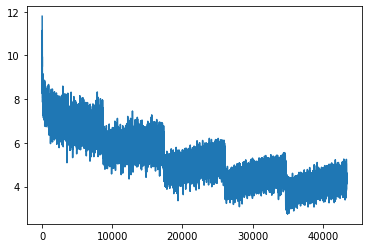

Evaluation: 100%|██████████| 2765/2765 [02:17<00:00, 20.07it/s]


1968.9958841573948
Art Deco architecture in the late 1930s and early 1960s the early 1960s and 1970s began in the 1930s with the increasing number of years before the age of10.963915
11.408741


In [6]:
# build_model.py

# import so we can pause the execution
import sys

# imports copied from lab3
import torch
import random
import numpy as np
from typing import List, Tuple
from torch.utils.data import Dataset, DataLoader
from torch import nn
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim import Adam, RMSprop

# read data from tag-formatted-files
#import read_data

# for tokenization
from nltk.tokenize import word_tokenize
import re

# code taken from lab3 notebook:
# https://colab.research.google.com/drive/1IeAOa4NWHu8q6sL6Gb54M1TiOWW-4f56?usp=sharing


# tokenizers
def regex_tokenizer(txt):
    # here words are tokenized only
    # hence not eg. symbols like ',' or '['
    rx_en = "[a-zA-Z0-9\\-]+|[a-zA-Z0-9\\-]+'[a-zA-Z0-9\\-]*"
    return re.findall(rx_en,txt)

def regex_tokenizer_lower(txt):
    # the same as above, though all words are lower cased
    return [t.lower() for t in regex_tokenizer(txt)]

def lab_tokenizer(txt):
    retval = []
    for line in txt.split("\n"):
        tokens = line.strip().split(" ")
        retval += tokens
    return retval

def get_data(entries,sizes):
    # We just concat question and doc with a space ' ' between
    train,test,valid = [],[],[]
    for t in entries[0:sizes[0]]:
        train.append(t["question_txt"] + " " + t["doc_txt"])
    for t in entries[sizes[0]:sizes[0] + sizes[1]]:
        test.append(t["question_txt"] + " " + t["doc_txt"])
    for t in entries[sizes[0] + sizes[1]:sizes[0] + sizes[1] + sizes[2]]:
        valid.append(t["question_txt"] + " " + t["doc_txt"])
    return (train,test,valid)

# we always do this
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently 
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)
enforce_reproducibility()


# We build a vocab using the py-class from the lab
class Vocab:
  def __init__(self):
    self.word2idx = {}
    self.idx2word = []

  def add_word(self, word):
    if word not in self.word2idx:
      self.idx2word.append(word)
      self.word2idx[word] = len(self.idx2word) - 1
    return self.word2idx[word]
    
  def to_words(self, ids):
    return [self.idx2word[idx] for idx in ids]

  def to_ids(self, words):
    return [self.add_word(word) for word in words]

  def __len__(self):
    return len(self.idx2word)

def build_vocab():
    vocabulary = Vocab()
    vocabulary.add_word('<eos>') # include a token indicating the end of a string
    vocabulary.add_word('<pad>') # include a token for padding
    vocabulary.add_word("<unk>") # include a token for unknown

    for entry in train_data + test_data + valid_data:
        # using specialized tokenizer results in less tokens
        # since eg. 'Stadium.[1]' is different from 'Stadium'
        tokens = tokenize(entry)
        for token in tokens:
            vocabulary.add_word(token)

    print(len(vocabulary))

    return vocabulary

# read in the dataset
class TxtDatasetReader(Dataset):
    # This reader creates sequences of length of seq_len
    def __init__(self, entries: str, vocab: Vocab, seq_len: int):

        self.vocab = vocab
        self.dataset = []

        for document in entries:
            #tokens = [token for token in document.split(' ') if len(token) > 0]
            tokens = tokenize(document)
            if len(tokens) <= 1:
                # skip empty rows
                continue

            # iterate through the wiki document with a window of size seq_len
            # each window is a separate instance
            doc_instances = [tokens[i:i+seq_len] for i in range(0, len(tokens), seq_len)]
    
            # pad the last window, which can be shorter than seq_len
            doc_instances[-1] = doc_instances[-1] + ['<pad>'] * (seq_len - len(doc_instances[-1]))
            self.dataset.extend(doc_instances)

        # truncate last incomplete batch (the hidden states for the RNN have the shape of the batch)
        self.dataset = self.dataset[:(len(self.dataset)-(len(self.dataset) % batch_size))]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx: int):
        # return some sequence with idx as index
        return self.vocab.to_ids(self.dataset[idx])


def collate_batch_bilstm(input_t: List) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    """
    Combines multiple data samples into a single batch
    :param input_t: The token input ids
    :return: A tuple of tensors (input_ids, targets, input_lens)
    """
    input_data = torch.tensor(input_t)

    
    # we don't use the last position as there isn't anything left for generation
    input_ids = input_data[:, :-1]
    # the length of every id, used for packing
    input_lens = [len(ids) for ids in input_ids]
    input_lens = torch.tensor(input_lens)
    # the target at each step is to generate the next word from the sequence
    # so we shift the token ids with 1 position
    targets = input_data[:, 1:]
    return input_ids, targets, input_lens

# Define the model
class LSTMNetwork(nn.Module):
    """
    Basic LSTM network
    """
    def __init__(
            self,
            vocab_size: int, 
            embeddings_dim: int,
            lstm_dim: int,       
            n_words: int,      
            dropout_prob: float = 0.0,
            lstm_layers: int = 1,
    ):
        """
        Initializer for basic BiLSTM network
        :param pretrained_embeddings: A tensor containing the pretrained BPE embeddings
        :param lstm_dim: The dimensionality of the BiLSTM network
        :param dropout_prob: Dropout probability
        :param n_classes: The number of output classes
        """

        # First thing is to call the superclass initializer
        super(LSTMNetwork, self).__init__()

        # We'll define the network in a ModuleDict, which makes organizing the model a bit nicer
        # The components are an embedding layer, a 2 layer LSTM, and a feed-forward output layer
        self.vocab_size = vocab_size
        self.model = nn.ModuleDict({
            'embeddings': nn.Embedding(vocab_size, embeddings_dim),
            'lstm': nn.LSTM( 
                embeddings_dim,
                lstm_dim,
                num_layers=lstm_layers,
                batch_first=True,
                dropout=dropout_prob),
            'ff': nn.Linear(lstm_dim, vocab_size),
        })

        # Initialize the weights of the model
        self._init_weights()

    def _init_weights(self):
        all_params = list(self.model['lstm'].named_parameters()) + \
                     list(self.model['ff'].named_parameters())
        for n, p in all_params:
            if 'weight' in n:
                nn.init.xavier_normal_(p)
            elif 'bias' in n:
                nn.init.zeros_(p)

    def forward(self, input_ids, input_lens, hidden_states):
        """
        Defines how tensors flow through the model
        :param input_ids: (b x sl) The IDs into the vocabulary of the input samples
        :param hidden_states: (b x sl) x 2 Hidden states for the LSTM model
        :return: (lstm output, updated hidden stated)
        """

        # Get embeddings (b x sl x edim)
        embeds = self.model['embeddings'](input_ids)

        # Pack padded: This is necessary for padded batches input to an RNN
        lstm_in = nn.utils.rnn.pack_padded_sequence(
            embeds,
            input_lens,
            batch_first=True,
            enforce_sorted=False
        )
      
        # Pass the sequence through the BiLSTM
        lstm_out, hidden_states = self.model['lstm'](lstm_in,hidden_states)

        # Unpack the packed sequence --> (b x sl x 2*lstm_dim)
        lstm_out,_ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)
        
        lstm_out = lstm_out.reshape(lstm_out.size(0)*lstm_out.size(1), lstm_out.size(2))
        lstm_out = self.model['ff'](lstm_out)
        return lstm_out, hidden_states


def evaluate(model: nn.Module, valid_dl: DataLoader):
  """
  Evaluates the model on the given dataset
  :param model: The model under evaluation
  :param valid_dl: A `DataLoader` reading validation data
  :return: The accuracy of the model on the dataset
  """
  model.eval()
  loss_all = []
  states = (torch.zeros(lstm_layers, batch_size, lstm_dim).to(device),
              torch.zeros(lstm_layers, batch_size, lstm_dim).to(device))
  loss_fn = nn.CrossEntropyLoss()
        
  with torch.no_grad():
    for batch in tqdm(valid_dl, desc='Evaluation'):
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      targets = batch[1]
      input_lens = batch[2]
      states = detach(states)
      logits, states = model(input_ids, input_lens, states)
      loss = loss_fn(logits, targets.reshape(-1))

      loss_all.append(loss.detach().cpu().numpy())

  perplexity = np.exp(sum(loss_all) / (len(loss_all)))
  return perplexity

# Truncated backpropagation
def detach(states):
    return [state.detach() for state in states]

def train(
    model: nn.Module, 
    train_dl: DataLoader, 
    valid_dl: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    n_epochs: int, 
    device: torch.device
):
  """
  The main training loop which will optimize a given model on a given dataset
  :param model: The model being optimized
  :param train_dl: The training dataset
  :param valid_dl: A validation dataset
  :param optimizer: The optimizer used to update the model parameters
  :param n_epochs: Number of epochs to train for
  :param device: The device to train on
  :return: (model, losses) The best model and the losses per iteration
  """

  # Keep track of the loss and best accuracy
  losses = []
  best_perplexity = 300.0
  # Set initial hidden and cell states
  loss_fn = nn.CrossEntropyLoss()
  # Iterate through epochs
  for ep in range(n_epochs):
    states = (torch.zeros(lstm_layers, batch_size, lstm_dim).to(device),
              torch.zeros(lstm_layers, batch_size, lstm_dim).to(device))
 
    loss_epoch = []

    #Iterate through each batch in the dataloader
    for batch in tqdm(train_dl):
      # VERY IMPORTANT: Make sure the model is in training mode, which turns on 
      # things like dropout and layer normalization
      model.train()

      # VERY IMPORTANT: zero out all of the gradients on each iteration -- PyTorch
      # keeps track of these dynamically in its computation graph so you need to explicitly
      # zero them out
      optimizer.zero_grad()

      # Place each tensor on the GPU
      batch = tuple(t.to(device) for t in batch)
      input_ids = batch[0]
      targets = batch[1]
      input_lens = batch[2]
      # Pass the inputs through the model, get the current loss and logits
      states = detach(states)
      logits, states = model(input_ids, input_lens, states)
      loss = loss_fn(logits, targets.reshape(-1))

      losses.append(loss.item())
      loss_epoch.append(loss.item())
      
      # Calculate all of the gradients and weight updates for the model
      loss.backward()

      # Optional: clip gradients
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      # Finally, update the weights of the model
      optimizer.step()
      #gc.collect()

    # Perform inline evaluation at the end of the epoch
    perplexity = evaluate(model, valid_dl)
    print(f'Validation perplexity: {perplexity}, train loss: {sum(loss_epoch) / len(loss_epoch)}')

    # Keep track of the best model based on the accuracy
    best_model = model.state_dict()
    if perplexity < best_perplexity:
      best_model = model.state_dict()
      best_perplexity = perplexity

  model.load_state_dict(best_model)
  return model, losses

def build_model(model):
    # Create the optimizer
    optimizer = Adam(model.parameters(), lr=lr)

    # Train
    model, losses = train(model, train_dl, valid_dl, optimizer, n_epochs, device)

    # Save the model
    torch.save(model.state_dict(), model_file_name)

    # Plot losses
    plt.plot(losses)
    plt.show()

def gen_text():
    states = (torch.zeros(lstm_layers, 1, lstm_dim).to(device),
              torch.zeros(lstm_layers, 1, lstm_dim).to(device))

    sentence_start = "Art Deco"
    unk_token_id = vocabulary.word2idx['<unk>']
    new_token = None

    while new_token != '<eos>' and len(sentence_start.split()) < 29:
        tokens = tokenize(sentence_start)
        token_idx = len(tokens)

        tokens = tokens + ['<pad>'] * (seq_len - len(tokens))

        token_ids = [vocabulary.word2idx.get(token,unk_token_id) for token in tokens]
        batch = collate_batch_bilstm([token_ids])

        logits, states = model(batch[0].to(device), batch[2] , states)
        logits = logits.detach().cpu().numpy()[token_idx - 1]


        new_token_id = np.argmax(logits)
        new_token = vocabulary.idx2word[new_token_id]
        sentence_start = sentence_start + ' ' + new_token
        print('\r'+sentence_start, end='')

def get_sentence_perplexity(sentence, model, vocabulary, seq_len):
  states = (torch.zeros(lstm_layers, 1, lstm_dim).to(device),
              torch.zeros(lstm_layers, 1, lstm_dim).to(device))
  unk_token_id = vocabulary.word2idx['<unk>']

  tokens = sentence.split()
  tokens = tokens[:seq_len]
  tokens = tokens + ['<pad>'] * (seq_len - len(tokens))
  token_ids = [vocabulary.word2idx.get(token,unk_token_id) for token in tokens]

  batch = collate_batch_bilstm([token_ids])
  loss_fn = torch.nn.CrossEntropyLoss()
  logits, states = model(batch[0].to(device), batch[2], states)
  loss = loss_fn(logits, batch[1].to(device).reshape(-1))
  loss = loss.detach().cpu().numpy()
  return np.exp(loss)

arr_string = ["", ""]
arr_languages = ["eng"] #, "fin", "ara", "kor"]
for language in arr_languages: 

  # if = True, model is build.
  # if = False the model is run
  do_build_model = True

  # chooese tokenizer
  #tokenize = lab_tokenizer
  #tokenize = word_tokenize
  #tokenize = regex_tokenizer
  tokenize = regex_tokenizer_lower


  training_file = "train-"+language+".txt"
  dev_file = "dev-"+language+".txt"
  model_file_name = "/content/drive/My Drive/NLP 2020W/models/model_"+language+"_1000_regexlower"

  data_all_train = get_data_2(training_file)


  #train_size = read_data.get_size(training_file) # = 9211
  # My GPU does not have enough vRAM to compute the full set
  # So use nr records equal to size_total
  size_total = 1000
  # Sizes for train,test,valid parts of training set
  data_train_slices = (int(0.6*size_total),int(0.2*size_total),int(0.2*size_total))

  # Parameters for sequencing
  seq_len = 35
  # Batch_size has been lowered from 128
  # If too high, it might result in cuda mem-errors
  batch_size = 8

  train_data,test_data,valid_data = get_data(data_all_train,data_train_slices)

  vocabulary = build_vocab()

  test_dataset = TxtDatasetReader(test_data, vocabulary, seq_len)

  device = torch.device("cpu")
  if torch.cuda.is_available():
      print("has cuda")
      device = torch.device("cuda")

  # Define some hyperparameters
  lr = 0.001
  n_epochs = 5
  lstm_dim = 1024
  lstm_layers = 1
  embeddings_dim = 128

  val_dataset = TxtDatasetReader(valid_data, vocabulary, seq_len)
  train_dataset = TxtDatasetReader(train_data, vocabulary, seq_len)

  valid_dl = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_batch_bilstm, num_workers=8)
  train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True , collate_fn=collate_batch_bilstm, num_workers=8)

  model = LSTMNetwork(
      embeddings_dim=embeddings_dim,
      vocab_size = len(vocabulary.word2idx),
      lstm_dim=lstm_dim, 
      dropout_prob=0.1, 
      n_words=seq_len, 
      lstm_layers=lstm_layers
    ).to(device)


  if do_build_model:    
      build_model(model)

  # Use model
  model.load_state_dict(torch.load(model_file_name))
  test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch_bilstm, num_workers=8)
  print(evaluate(model, test_dl))


  gen_text()
  if language == "eng":
    arr_string[0] = 'I want to buy some potatoes from the airport.'
    arr_string[1] = 'gibberish ? . something something is'
  #if language == "fin":
  #  arr_string[0] = 'Haluan ostaa perunoita lentokentältä.'
  #  arr_string[1] = 'pilkkaa? . jotain jotain on'
  #if language == "ara":
  #  arr_string[0] = 'أريد شراء بعض البطاطس من المطار.'
  #  arr_string[1] = 'ثرثرة؟ . شيء ما'
  #if language == "kor":
  #  arr_string[0] = '공항에서 감자를 좀 사고 싶어요.'
  #  arr_string[1] = '횡설수설? . 뭔가 뭔가'
    
  print20 = get_sentence_perplexity(arr_string[0], model, vocabulary, seq_len)
  print21 = get_sentence_perplexity(arr_string[1], model, vocabulary, seq_len)
  print(print20)
  print(print21)
